Depth data shape from saxena_monocular_depth_2\combined1-p-170t0.dat: (107, 86)


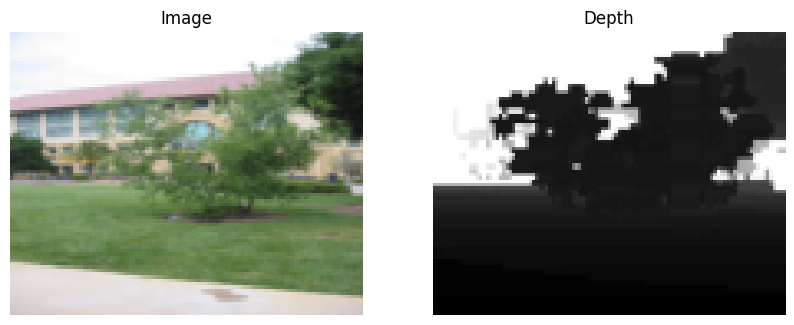

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class Custom3DDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.files)

    def load_depth_data(self, depth_path):
        with open(depth_path, 'r') as f:
            depth_data = []
            for line in f:
                depth_data.append(list(map(float, line.strip().split())))

        depth_array = np.array(depth_data, dtype=np.float32)
        print(f'Depth data shape from {depth_path}: {depth_array.shape}')
        return Image.fromarray(depth_array).convert("L")

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.data_dir, img_name)
        depth_path = os.path.join(self.data_dir, img_name.replace('.jpg', '.dat'))

        image = Image.open(img_path).convert("RGB")
        depth = self.load_depth_data(depth_path)

        sample = {"image": image, "depth": depth}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
            if depth is not None:
                depth = self.transform(depth)
                sample['depth'] = depth

        return sample

def visualize_dataset(dataset):
    for i in range(len(dataset)):
        sample = dataset[2]
        image = sample['image']
        depth = sample.get('depth')

        plt.figure(figsize=(10, 5))

        if image.ndim == 3:
            image = image.permute(1, 2, 0).numpy()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')

        if depth is not None:
            plt.subplot(1, 2, 2)
            depth = depth.squeeze().numpy()
            plt.imshow(depth, cmap='gray')
            plt.title('Depth')
            plt.axis('off')
        else:
            print("Depth data is not available.")

        plt.show()
        break
data_directory = 'saxena_monocular_depth_2'

# Create the dataset
transform = transforms.Compose([
    transforms.Resize((86, 107)),
    transforms.ToTensor(),
])

dataset = Custom3DDataset(data_directory, transform)

# Visualize the dataset
visualize_dataset(dataset)


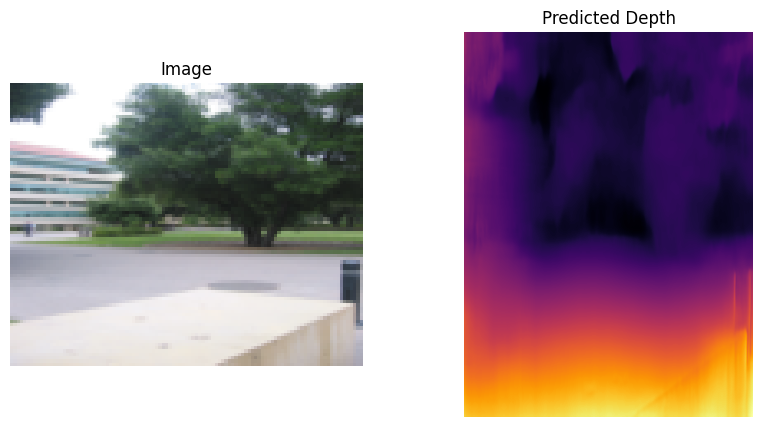

In [8]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import sys

# Add your Monodepth2 repo to the Python path
sys.path.append('D:/project/monodepth2')  # Update this path to your local Monodepth2 repo

from monodepth2 import networks  # Import the networks module

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Monodepth2 models
def load_monodepth2_models(model_path):
    # Initialize the encoder
    encoder = networks.ResnetEncoder(18, False)  # Adjust these parameters if necessary

    # Load the encoder state
    encoder_state_dict = torch.load(os.path.join(model_path, 'encoder.pth'), map_location=device)

    # Remove unexpected keys
    if 'height' in encoder_state_dict:
        del encoder_state_dict['height']
    if 'width' in encoder_state_dict:
        del encoder_state_dict['width']
    if 'use_stereo' in encoder_state_dict:
        del encoder_state_dict['use_stereo']

    encoder.load_state_dict(encoder_state_dict)
    encoder.to(device).eval()

    # Get the number of channels from the encoder
    num_ch_enc = encoder.num_ch_enc  # Assuming `num_ch_enc` is an attribute of the encoder

    # Initialize the depth decoder with the correct number of channels
    depth_decoder = networks.DepthDecoder(num_ch_enc)

    # Load the depth decoder state
    depth_decoder.load_state_dict(torch.load(os.path.join(model_path, 'depth.pth'), map_location=device))
    depth_decoder.to(device).eval()
    
    return encoder, depth_decoder

# Predict depth
def predict_depth_monodepth2(image, encoder, depth_decoder):
    input_image = image.resize((640, 192))
    input_image = transforms.ToTensor()(input_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = encoder(input_image)
        outputs = depth_decoder(features)
        depth = outputs[("disp", 0)]
    
    depth_resized = torch.nn.functional.interpolate(
        depth, size=image.size[::-1], mode="bilinear", align_corners=False
    )
    
    depth_map = depth_resized.squeeze().cpu().numpy()
    return depth_map

# Dataset class
class Custom3DDataset(Dataset):
    def __init__(self, data_dir, transform=None, encoder=None, depth_decoder=None):
        self.data_dir = data_dir
        self.transform = transform
        self.encoder = encoder
        self.depth_decoder = depth_decoder
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        depth = predict_depth_monodepth2(image, self.encoder, self.depth_decoder)

        sample = {"image": image, "depth": depth}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
            sample['depth'] = torch.tensor(sample['depth']).unsqueeze(0)

        return sample

def visualize_dataset(dataset):
    for i in range(len(dataset)):
        sample = dataset[5]
        image = sample['image']
        depth = sample['depth']

        plt.figure(figsize=(10, 5))

        # Display the RGB image
        plt.subplot(1, 2, 1)
        # Change this line to permute the dimensions for matplotlib
        image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')

        # Display the predicted depth image
        plt.subplot(1, 2, 2)
        plt.imshow(depth.squeeze().numpy(), cmap='inferno')
        plt.title('Predicted Depth')
        plt.axis('off')

        plt.show()
        break  # Remove this if you want to visualize all samples

# Main execution
model_directory = 'D:/project/models'  # Replace with the path to your .pth files
encoder, depth_decoder = load_monodepth2_models(model_directory)

data_directory = 'saxena_monocular_depth_2'  # Your image dataset directory

transform = transforms.Compose([
    transforms.Resize((86, 107)),
    transforms.ToTensor(),
])

dataset = Custom3DDataset(data_directory, transform, encoder, depth_decoder)

# Visualize the dataset with predicted depth
visualize_dataset(dataset)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


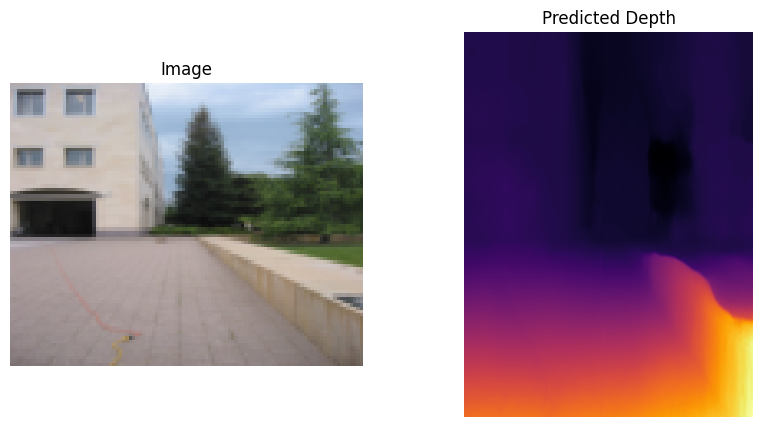

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

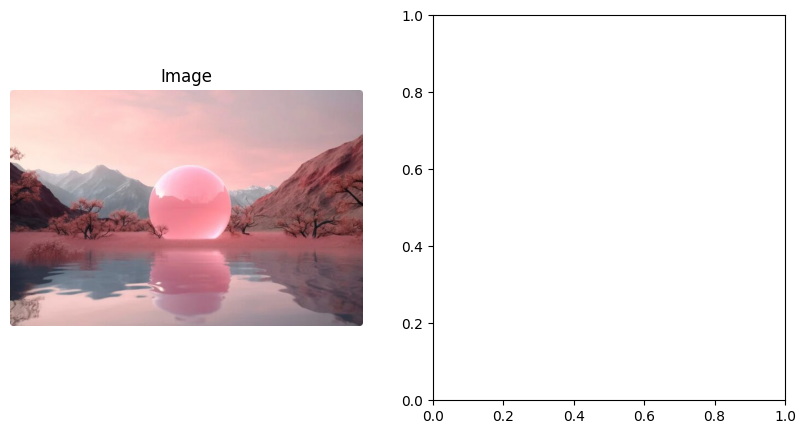

In [10]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import sys

# Add your Monodepth2 repo to the Python path
sys.path.append('D:/project/monodepth2')  # Update this path to your local Monodepth2 repo

from monodepth2 import networks  # Import the networks module

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Monodepth2 models
def load_monodepth2_models(model_path):
    # Initialize the encoder
    encoder = networks.ResnetEncoder(18, False)  # Adjust these parameters if necessary

    # Load the encoder state
    encoder_state_dict = torch.load(os.path.join(model_path, 'encoder.pth'), map_location=device)

    # Remove unexpected keys
    for key in ['height', 'width', 'use_stereo']:
        encoder_state_dict.pop(key, None)

    encoder.load_state_dict(encoder_state_dict)
    encoder.to(device).eval()

    # Get the number of channels from the encoder
    num_ch_enc = encoder.num_ch_enc  # Assuming `num_ch_enc` is an attribute of the encoder

    # Initialize the depth decoder with the correct number of channels
    depth_decoder = networks.DepthDecoder(num_ch_enc)

    # Load the depth decoder state
    depth_decoder.load_state_dict(torch.load(os.path.join(model_path, 'depth.pth'), map_location=device))
    depth_decoder.to(device).eval()
    
    return encoder, depth_decoder

# Predict depth
def predict_depth_monodepth2(image, encoder, depth_decoder):
    input_image = image.resize((640, 192))  # Resize image to model input size
    input_image = transforms.ToTensor()(input_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = encoder(input_image)
        outputs = depth_decoder(features)
        depth = outputs[("disp", 0)]
    
    # Resize depth map to original image size
    depth_resized = torch.nn.functional.interpolate(
        depth, size=image.size[::-1], mode="bilinear", align_corners=False
    )
    
    depth_map = depth_resized.squeeze().cpu().numpy()  # Convert to numpy array
    return depth_map

# Dataset class
class Custom3DDataset(Dataset):
    def __init__(self, data_dir, transform=None, encoder=None, depth_decoder=None):
        self.data_dir = data_dir
        self.transform = transform
        self.encoder = encoder
        self.depth_decoder = depth_decoder
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.jpg') or f.endswith('.jpeg')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        depth = predict_depth_monodepth2(image, self.encoder, self.depth_decoder)

        sample = {"image": image, "depth": depth}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
            sample['depth'] = torch.tensor(sample['depth']).unsqueeze(0)

        return sample

# Function to predict depth for a single image
def predict_depth_for_single_image(image_path, encoder, depth_decoder):
    image = Image.open(image_path).convert("RGB")
    depth_map = predict_depth_monodepth2(image, encoder, depth_decoder)
    return image, depth_map

# Function to visualize the dataset or a single image
def visualize_image_and_depth(image, depth):
    plt.figure(figsize=(10, 5))

    # Display the RGB image
    plt.subplot(1, 2, 1)
    image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Display the predicted depth image
    plt.subplot(1, 2, 2)
    plt.imshow(depth.squeeze().numpy(), cmap='inferno')
    plt.title('Predicted Depth')
    plt.axis('off')

    plt.show()

# Main execution
model_directory = 'D:/project/models'  # Replace with the path to your .pth files
encoder, depth_decoder = load_monodepth2_models(model_directory)

# Example usage for dataset
data_directory = 'saxena_monocular_depth_2'  # Your image dataset directory
transform = transforms.Compose([
    transforms.Resize((86, 107)),  # Adjust as necessary
    transforms.ToTensor(),
])

dataset = Custom3DDataset(data_directory, transform, encoder, depth_decoder)

# Visualize the dataset with predicted depth
visualize_image_and_depth(dataset[0]['image'], dataset[0]['depth'])  # Visualizing the first sample

# Example usage for predicting a single image
single_image_path = 'subhome-ai.jpeg'  # Replace with your image path
image, depth_map = predict_depth_for_single_image(single_image_path, encoder, depth_decoder)
visualize_image_and_depth(transforms.ToTensor()(image), depth_map)  # Visualizing the single image prediction


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


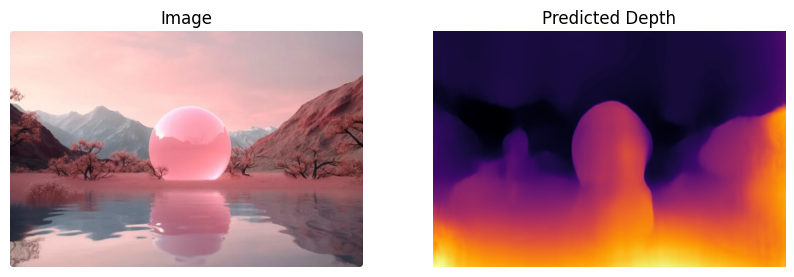

In [1]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import sys

# Add your Monodepth2 repo to the Python path
sys.path.append('D:/project/monodepth2')  # Update this path to your local Monodepth2 repo

from monodepth2 import networks  # Import the networks module

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Monodepth2 models
def load_monodepth2_models(model_path):
    encoder = networks.ResnetEncoder(18, False)  # Initialize the encoder
    encoder_state_dict = torch.load(os.path.join(model_path, 'encoder.pth'), map_location=device)
    
    # Remove unexpected keys
    if 'height' in encoder_state_dict:
        del encoder_state_dict['height']
    if 'width' in encoder_state_dict:
        del encoder_state_dict['width']
    if 'use_stereo' in encoder_state_dict:
        del encoder_state_dict['use_stereo']

    encoder.load_state_dict(encoder_state_dict)
    encoder.to(device).eval()

    num_ch_enc = encoder.num_ch_enc
    depth_decoder = networks.DepthDecoder(num_ch_enc)

    depth_decoder.load_state_dict(torch.load(os.path.join(model_path, 'depth.pth'), map_location=device))
    depth_decoder.to(device).eval()
    
    return encoder, depth_decoder

# Predict depth for a single image
def predict_depth_for_single_image(image_path, encoder, depth_decoder):
    image = Image.open(image_path).convert("RGB")  # Open and convert the image
    input_image = image.resize((640, 192))  # Resize to model input size
    input_image = transforms.ToTensor()(input_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = encoder(input_image)
        outputs = depth_decoder(features)
        depth = outputs[("disp", 0)]

    depth_resized = torch.nn.functional.interpolate(
        depth, size=image.size[::-1], mode="bilinear", align_corners=False
    )
    
    depth_map = depth_resized.squeeze().cpu().numpy()  # Convert to NumPy array
    return image, depth_map  # Return both image and depth map

# Visualize single image and depth map
def visualize_image_and_depth(image, depth_map):
    plt.figure(figsize=(10, 5))

    # Display the RGB image
    plt.subplot(1, 2, 1)
    image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Display the predicted depth image
    plt.subplot(1, 2, 2)
    plt.imshow(depth_map, cmap='inferno')  # No need to call .numpy() since depth_map is already a NumPy array
    plt.title('Predicted Depth')
    plt.axis('off')

    plt.show()

# Main execution for a single image
model_directory = 'D:/project/models'  # Replace with the path to your .pth files
encoder, depth_decoder = load_monodepth2_models(model_directory)

single_image_path = 'subhome-ai.jpeg'  # Replace with your image path
image, depth_map = predict_depth_for_single_image(single_image_path, encoder, depth_decoder)
visualize_image_and_depth(transforms.ToTensor()(image), depth_map)  # Visualizing the single image prediction


In [19]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import open3d as o3d
import torchvision.transforms as transforms
import sys

# Add your Monodepth2 repo to the Python path
sys.path.append('D:/project/monodepth2')  # Update this path to your local Monodepth2 repo

from monodepth2 import networks  # Import the networks module

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Monodepth2 models
def load_monodepth2_models(model_path):
    # Initialize the encoder
    encoder = networks.ResnetEncoder(18, False)  # Adjust these parameters if necessary

    # Load the encoder state
    encoder_state_dict = torch.load(os.path.join(model_path, 'encoder.pth'), map_location=device)

    # Remove unexpected keys
    if 'height' in encoder_state_dict:
        del encoder_state_dict['height']
    if 'width' in encoder_state_dict:
        del encoder_state_dict['width']
    if 'use_stereo' in encoder_state_dict:
        del encoder_state_dict['use_stereo']

    encoder.load_state_dict(encoder_state_dict)
    encoder.to(device).eval()

    # Get the number of channels from the encoder
    num_ch_enc = encoder.num_ch_enc  # Assuming `num_ch_enc` is an attribute of the encoder

    # Initialize the depth decoder with the correct number of channels
    depth_decoder = networks.DepthDecoder(num_ch_enc)

    # Load the depth decoder state
    depth_decoder.load_state_dict(torch.load(os.path.join(model_path, 'depth.pth'), map_location=device))
    depth_decoder.to(device).eval()
    
    return encoder, depth_decoder

# Predict depth
def predict_depth_monodepth2(image, encoder, depth_decoder):
    input_image = image.resize((640, 192))
    input_image = transforms.ToTensor()(input_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = encoder(input_image)
        outputs = depth_decoder(features)
        depth = outputs[("disp", 0)]
    
    depth_resized = torch.nn.functional.interpolate(
        depth, size=image.size[::-1], mode="bilinear", align_corners=False
    )
    
    depth_map = depth_resized.squeeze().cpu().numpy()
    return depth_map

# Create 3D point cloud from image and depth map
def create_point_cloud(image, depth_map):
    height, width = depth_map.shape

    # Create a mesh grid for pixel coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Flatten the arrays
    x = x.flatten()
    y = y.flatten()
    z = depth_map.flatten()

    # Create point cloud data
    points = np.vstack((x, y, z)).T

    # Create a color array from the original image
    colors = np.array(image).reshape(-1, 3) / 255.0  # Normalize color values

    # Create an Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    return pcd

# Visualize the 3D point cloud
def visualize_point_cloud(pcd):
    o3d.visualization.draw_geometries([pcd])

# Main execution
if __name__ == "__main__":
    model_directory = 'D:/project/models'  # Replace with the path to your .pth files
    encoder, depth_decoder = load_monodepth2_models(model_directory)

    # Path to the image you want to convert
    single_image_path = 'How-to-draw-a-human-1.jpg.webp'  # Replace with your image path
    image = Image.open(single_image_path).convert("RGB")

    # Predict the depth map
    depth_map = predict_depth_monodepth2(image, encoder, depth_decoder)

    # Create the 3D point cloud
    point_cloud = create_point_cloud(image, depth_map)

    # Visualize the point cloud
    visualize_point_cloud(point_cloud)


In [1]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import open3d as o3d
import torchvision.transforms as transforms
import sys
from scipy.ndimage import zoom

# Add your Monodepth2 repo to the Python path
sys.path.append('D:/project/monodepth2')  # Update this path to your local Monodepth2 repo

from monodepth2 import networks  # Import the networks module

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Monodepth2 models
def load_monodepth2_models(model_path):
    # Initialize the encoder
    encoder = networks.ResnetEncoder(18, False)

    # Load the encoder state
    encoder_state_dict = torch.load(os.path.join(model_path, 'encoder.pth'), map_location=device)

    # Remove unexpected keys
    if 'height' in encoder_state_dict:
        del encoder_state_dict['height']
    if 'width' in encoder_state_dict:
        del encoder_state_dict['width']
    if 'use_stereo' in encoder_state_dict:
        del encoder_state_dict['use_stereo']

    encoder.load_state_dict(encoder_state_dict)
    encoder.to(device).eval()

    # Get the number of channels from the encoder
    num_ch_enc = encoder.num_ch_enc

    # Initialize the depth decoder with the correct number of channels
    depth_decoder = networks.DepthDecoder(num_ch_enc)

    # Load the depth decoder state
    depth_decoder.load_state_dict(torch.load(os.path.join(model_path, 'depth.pth'), map_location=device))
    depth_decoder.to(device).eval()
    
    return encoder, depth_decoder

# Predict depth for a single image
def predict_depth_monodepth2(image, encoder, depth_decoder):
    input_image = image.resize((640, 192))  # Resize to match the model's input size
    input_image = transforms.ToTensor()(input_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = encoder(input_image)
        outputs = depth_decoder(features)
        disparity = outputs[("disp", 0)]
    
    disparity_resized = torch.nn.functional.interpolate(
        disparity, size=image.size[::-1], mode="bilinear", align_corners=False
    )
    
    # Convert disparity to depth (scaling the disparity)
    depth_map = 1.0 / disparity_resized.squeeze().cpu().numpy()
    
    return depth_map

# Merge the depth maps from front and back images
def merge_depth_maps(depth_map_front, depth_map_back):
    # Resize the back depth map to match the front depth map's shape
    if depth_map_front.shape != depth_map_back.shape:
        height_ratio = depth_map_front.shape[0] / depth_map_back.shape[0]
        width_ratio = depth_map_front.shape[1] / depth_map_back.shape[1]
        depth_map_back_resized = zoom(depth_map_back, (height_ratio, width_ratio))
    else:
        depth_map_back_resized = depth_map_back
    
    # Average the front and back depth maps
    combined_depth_map = (depth_map_front + depth_map_back_resized) / 2.0
    return combined_depth_map

# Create 3D point cloud from image and depth map
def create_point_cloud(image, depth_map, scale_factor=1.0):
    height, width = depth_map.shape

    # Approximate camera intrinsics (you can replace with real values if known)
    fx = 0.58 * width  # Focal length in x-direction
    fy = 0.58 * height  # Focal length in y-direction
    cx = width / 2  # Principal point x-coordinate
    cy = height / 2  # Principal point y-coordinate

    # Create mesh grid for pixel coordinates
    u, v = np.meshgrid(np.arange(width), np.arange(height))

    # Flatten the arrays
    u = u.flatten()
    v = v.flatten()
    z = depth_map.flatten() * scale_factor  # Apply depth scaling

    # Convert pixel coordinates to 3D coordinates
    x = (u - cx) * z / fx
    y = (v - cy) * z / fy

    points = np.vstack((x, y, z)).T

    # Create a color array from the original image
    colors = np.array(image).reshape(-1, 3) / 255.0  # Normalize RGB values

    # Create an Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    return pcd

# Visualize the 3D point cloud
def visualize_point_cloud(pcd):
    o3d.visualization.draw_geometries([pcd])

# Main execution
if __name__ == "__main__":
    model_directory = 'D:/project/models'  # Replace with the path to your .pth files
    encoder, depth_decoder = load_monodepth2_models(model_directory)

    # Load front and back images
    front_image_path = 'Screenshot 2024-10-17 012730.png'  # Replace with your front image path
    back_image_path = 'Screenshot 2024-10-17 012802.png'  # Replace with your back image path
    
    front_image = Image.open(front_image_path).convert("RGB")
    back_image = Image.open(back_image_path).convert("RGB")

    # Predict the depth maps for both images
    depth_map_front = predict_depth_monodepth2(front_image, encoder, depth_decoder)
    depth_map_back = predict_depth_monodepth2(back_image, encoder, depth_decoder)

    # Merge the depth maps from front and back images
    combined_depth_map = merge_depth_maps(depth_map_front, depth_map_back)

    # Create the 3D point cloud from the combined depth map
    point_cloud = create_point_cloud(front_image, combined_depth_map)  # Using the front image for colors

    # Visualize the point cloud
    visualize_point_cloud(point_cloud)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
import os
import torch
import numpy as np
from PIL import Image
import open3d as o3d
import torchvision.transforms as transforms
import cv2
from scipy.ndimage import zoom

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Monodepth2 models
def load_monodepth2_models(model_path):
    from monodepth2 import networks  # Import the networks module
    encoder = networks.ResnetEncoder(18, False)
    encoder_state_dict = torch.load(os.path.join(model_path, 'encoder.pth'), map_location=device)

    # Remove unexpected keys
    if 'height' in encoder_state_dict:
        del encoder_state_dict['height']
    if 'width' in encoder_state_dict:
        del encoder_state_dict['width']
    if 'use_stereo' in encoder_state_dict:
        del encoder_state_dict['use_stereo']

    encoder.load_state_dict(encoder_state_dict)
    encoder.to(device).eval()

    num_ch_enc = encoder.num_ch_enc
    depth_decoder = networks.DepthDecoder(num_ch_enc)
    depth_decoder.load_state_dict(torch.load(os.path.join(model_path, 'depth.pth'), map_location=device))
    depth_decoder.to(device).eval()

    return encoder, depth_decoder

# Predict depth for a single image
def predict_depth_monodepth2(image, encoder, depth_decoder):
    input_image = image.resize((640, 192))
    input_image = transforms.ToTensor()(input_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = encoder(input_image)
        outputs = depth_decoder(features)
        disparity = outputs[("disp", 0)]
    
    disparity_resized = torch.nn.functional.interpolate(
        disparity, size=image.size[::-1], mode="bilinear", align_corners=False
    )
    depth_map = 1.0 / disparity_resized.squeeze().cpu().numpy()
    return depth_map

# Calculate confidence map based on disparity gradient
def calculate_confidence_map(depth_map):
    grad_x = np.gradient(depth_map, axis=1)
    grad_y = np.gradient(depth_map, axis=0)
    confidence_map = np.exp(-np.sqrt(grad_x**2 + grad_y**2))  # Higher confidence in smoother regions
    return confidence_map

# Merge depth maps with confidence weighting
def merge_depth_maps_weighted(front_depth_map, back_depth_map):
    if front_depth_map.shape != back_depth_map.shape:
        # Resize back depth map to match front depth map shape
        height_ratio = front_depth_map.shape[0] / back_depth_map.shape[0]
        width_ratio = front_depth_map.shape[1] / back_depth_map.shape[1]
        back_depth_map = zoom(back_depth_map, (height_ratio, width_ratio))
    
    # Compute confidence maps for both depth maps
    front_confidence = calculate_confidence_map(front_depth_map)
    back_confidence = calculate_confidence_map(back_depth_map)

    # Weighted average based on confidence
    combined_depth_map = (front_depth_map * front_confidence + back_depth_map * back_confidence) / (front_confidence + back_confidence)
    return combined_depth_map

# Create 3D point cloud
def create_point_cloud(image, depth_map, scale_factor=1.0):
    height, width = depth_map.shape
    fx, fy = 0.58 * width, 0.58 * height
    cx, cy = width / 2, height / 2

    u, v = np.meshgrid(np.arange(width), np.arange(height))
    u, v, z = u.flatten(), v.flatten(), depth_map.flatten() * scale_factor
    x, y = (u - cx) * z / fx, (v - cy) * z / fy

    points = np.vstack((x, y, z)).T
    colors = np.array(image).reshape(-1, 3) / 255.0

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    return pcd

# Visualize point cloud
def visualize_point_cloud(pcd):
    o3d.visualization.draw_geometries([pcd])

# Main execution
if __name__ == "__main__":
    model_directory = 'D:/project/models'  # Replace with your model path
    encoder, depth_decoder = load_monodepth2_models(model_directory)

    front_image_path = 'Screenshot 2024-10-17 012730.png'  # Replace with your front image
    back_image_path = 'Screenshot 2024-10-17 012802.png'    # Replace with your back image
    
    front_image = Image.open(front_image_path).convert("RGB")
    back_image = Image.open(back_image_path).convert("RGB")

    depth_map_front = predict_depth_monodepth2(front_image, encoder, depth_decoder)
    depth_map_back = predict_depth_monodepth2(back_image, encoder, depth_decoder)

    combined_depth_map = merge_depth_maps_weighted(depth_map_front, depth_map_back)
    point_cloud = create_point_cloud(front_image, combined_depth_map)

    visualize_point_cloud(point_cloud)


In [1]:
import os
import torch
import numpy as np
from PIL import Image
import open3d as o3d
import torchvision.transforms as transforms
import cv2
from scipy.ndimage import zoom

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Monodepth2 models
def load_monodepth2_models(model_path):
    from monodepth2 import networks  # Import the networks module
    encoder = networks.ResnetEncoder(18, False)
    encoder_state_dict = torch.load(os.path.join(model_path, 'encoder.pth'), map_location=device)

    # Remove unexpected keys
    if 'height' in encoder_state_dict:
        del encoder_state_dict['height']
    if 'width' in encoder_state_dict:
        del encoder_state_dict['width']
    if 'use_stereo' in encoder_state_dict:
        del encoder_state_dict['use_stereo']

    encoder.load_state_dict(encoder_state_dict)
    encoder.to(device).eval()

    num_ch_enc = encoder.num_ch_enc
    depth_decoder = networks.DepthDecoder(num_ch_enc)
    depth_decoder.load_state_dict(torch.load(os.path.join(model_path, 'depth.pth'), map_location=device))
    depth_decoder.to(device).eval()

    return encoder, depth_decoder

# Predict depth for a single image
def predict_depth_monodepth2(image, encoder, depth_decoder):
    input_image = image.resize((640, 192))
    input_image = transforms.ToTensor()(input_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = encoder(input_image)
        outputs = depth_decoder(features)
        disparity = outputs[("disp", 0)]
    
    disparity_resized = torch.nn.functional.interpolate(
        disparity, size=image.size[::-1], mode="bilinear", align_corners=False
    )
    depth_map = 1.0 / disparity_resized.squeeze().cpu().numpy()
    return depth_map

# Calculate confidence map based on disparity gradient
def calculate_confidence_map(depth_map):
    grad_x = np.gradient(depth_map, axis=1)
    grad_y = np.gradient(depth_map, axis=0)
    confidence_map = np.exp(-np.sqrt(grad_x**2 + grad_y**2))  # Higher confidence in smoother regions
    return confidence_map

# Function to align images using ORB and homography
def align_images(front_image, back_image):
    # Convert images to grayscale
    front_gray = cv2.cvtColor(np.array(front_image), cv2.COLOR_RGB2GRAY)
    back_gray = cv2.cvtColor(np.array(back_image), cv2.COLOR_RGB2GRAY)

    # Initialize ORB detector
    orb = cv2.ORB_create(5000)

    # Detect keypoints and descriptors
    keypoints1, descriptors1 = orb.detectAndCompute(front_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(back_gray, None)

    # Match descriptors using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Select good matches (top 10%)
    num_good_matches = int(len(matches) * 0.1)
    good_matches = matches[:num_good_matches]

    # Extract the matched keypoints
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Compute the homography matrix
    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Warp the back image to align with the front image
    aligned_back_image = cv2.warpPerspective(np.array(back_image), H, (front_image.width, front_image.height))

    return aligned_back_image, H

# Align depth maps and merge them with confidence weighting
def merge_depth_maps_aligned(front_image, back_image, depth_map_front, depth_map_back):
    # Align the back image to the front image
    aligned_back_image, H = align_images(front_image, back_image)

    # Warp the back depth map to align with the front depth map
    aligned_back_depth_map = cv2.warpPerspective(depth_map_back, H, (depth_map_front.shape[1], depth_map_front.shape[0]))

    # Compute confidence maps for both depth maps
    front_confidence = calculate_confidence_map(depth_map_front)
    back_confidence = calculate_confidence_map(aligned_back_depth_map)

    # Weighted average based on confidence
    combined_depth_map = (depth_map_front * front_confidence + aligned_back_depth_map * back_confidence) / (front_confidence + back_confidence)
    return combined_depth_map

# Create 3D point cloud
def create_point_cloud(image, depth_map, scale_factor=1.0):
    height, width = depth_map.shape
    fx, fy = 0.58 * width, 0.58 * height
    cx, cy = width / 2, height / 2

    u, v = np.meshgrid(np.arange(width), np.arange(height))
    u, v, z = u.flatten(), v.flatten(), depth_map.flatten() * scale_factor
    x, y = (u - cx) * z / fx, (v - cy) * z / fy

    points = np.vstack((x, y, z)).T
    colors = np.array(image).reshape(-1, 3) / 255.0

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    return pcd

# Visualize point cloud
def visualize_point_cloud(pcd):
    o3d.visualization.draw_geometries([pcd])

# Main execution
if __name__ == "__main__":
    model_directory = 'D:/project/models'  # Replace with your model path
    encoder, depth_decoder = load_monodepth2_models(model_directory)

    front_image_path = 'Screenshot 2024-10-17 012730.png'  # Replace with your front image
    back_image_path = 'Screenshot 2024-10-17 012802.png'    # Replace with your back image
    
    front_image = Image.open(front_image_path).convert("RGB")
    back_image = Image.open(back_image_path).convert("RGB")

    depth_map_front = predict_depth_monodepth2(front_image, encoder, depth_decoder)
    depth_map_back = predict_depth_monodepth2(back_image, encoder, depth_decoder)

    combined_depth_map = merge_depth_maps_aligned(front_image, back_image, depth_map_front, depth_map_back)
    point_cloud = create_point_cloud(front_image, combined_depth_map)

    visualize_point_cloud(point_cloud)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
import os
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import open3d as o3d

# Device setup for CPU usage to avoid GPU memory issues
device = torch.device("cpu")

# Load Monodepth2 models for depth estimation
def load_monodepth2_models(model_path):
    from monodepth2 import networks
    encoder = networks.ResnetEncoder(18, False)
    encoder_state_dict = torch.load(os.path.join(model_path, 'encoder.pth'), map_location=device)
    for key in ['height', 'width', 'use_stereo']:
        encoder_state_dict.pop(key, None)
    encoder.load_state_dict(encoder_state_dict)
    encoder.to(device).eval()
    depth_decoder = networks.DepthDecoder(encoder.num_ch_enc)
    depth_decoder.load_state_dict(torch.load(os.path.join(model_path, 'depth.pth'), map_location=device))
    depth_decoder.to(device).eval()
    return encoder, depth_decoder

# Predict depth map for an image using Monodepth2
def predict_depth(image_path, encoder, depth_decoder, target_size=(160, 96)):
    image = Image.open(image_path).convert("RGB").resize(target_size)
    input_image = transforms.ToTensor()(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = encoder(input_image)
        outputs = depth_decoder(features)
        disparity = outputs[("disp", 0)]
    depth_map = 1.0 / disparity.squeeze().cpu().numpy()
    return depth_map

# Create a minimal point cloud from depth map
def create_point_cloud_from_depth(depth_map, color_image):
    height, width = depth_map.shape
    fx = 0.58 * width
    fy = 0.58 * height
    cx = width / 2
    cy = height / 2

    u, v = np.meshgrid(np.arange(width), np.arange(height))
    u, v, z = u.flatten(), v.flatten(), depth_map.flatten()
    x = (u - cx) * z / fx
    y = (v - cy) * z / fy

    # Stack and filter out points with invalid depth values
    points = np.vstack((x, y, z)).T
    mask = (z > 0) & (z < 100)  # Keep only valid depth values for memory efficiency
    points = points[mask]

    # Set colors for the point cloud, resizing to match depth map
    colors = np.array(color_image.resize((width, height))).reshape(-1, 3) / 255.0
    colors = colors[mask]  # Apply the mask to filter colors

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

# Main processing and visualization workflow
if __name__ == "__main__":
    model_path = 'models'  # Replace with your model path
    encoder, depth_decoder = load_monodepth2_models(model_path)

    # Predict depth maps for front and back images
    front_image_path = 'Screenshot 2024-10-17 012730.png'  # Replace with your front image path
    back_image_path = 'Screenshot 2024-10-17 012802.png'     # Replace with your back image path
    front_depth_map = predict_depth(front_image_path, encoder, depth_decoder)
    back_depth_map = predict_depth(back_image_path, encoder, depth_decoder)

    # Create point cloud from front depth map for visualization
    color_image = Image.open(front_image_path).convert("RGB").resize((160, 96))
    point_cloud = create_point_cloud_from_depth(front_depth_map, color_image)

    # Visualize the point cloud
    point_cloud = point_cloud.voxel_down_sample(voxel_size=0.001)
    o3d.visualization.draw_geometries([point_cloud])


In [15]:
import os
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import open3d as o3d
import cv2

# Device setup for CPU usage to avoid GPU memory issues
device = torch.device("cpu")

# Load Monodepth2 stereo models for depth estimation
def load_monodepth2_stereo_models(model_path):
    from monodepth2 import networks
    encoder = networks.ResnetEncoder(18, True)  # Use stereo model
    encoder_state_dict = torch.load(os.path.join(model_path, 'encoder.pth'), map_location=device)
    for key in ['height', 'width', 'use_stereo']:
        encoder_state_dict.pop(key, None)
    encoder.load_state_dict(encoder_state_dict)
    encoder.to(device).eval()
    depth_decoder = networks.DepthDecoder(encoder.num_ch_enc)
    depth_decoder.load_state_dict(torch.load(os.path.join(model_path, 'depth.pth'), map_location=device))
    depth_decoder.to(device).eval()
    return encoder, depth_decoder

# Predict depth map for stereo images
def predict_stereo_depth(front_image_path, back_image_path, encoder, depth_decoder, target_size=(640, 384)):
    front_image = Image.open(front_image_path).convert("RGB").resize(target_size)
    back_image = Image.open(back_image_path).convert("RGB").resize(target_size)

    input_front = transforms.ToTensor()(front_image).unsqueeze(0).to(device)
    input_back = transforms.ToTensor()(back_image).unsqueeze(0).to(device)

    with torch.no_grad():
        features_front = encoder(input_front)
        features_back = encoder(input_back)

        outputs_front = depth_decoder(features_front)
        outputs_back = depth_decoder(features_back)

        disparity_front = outputs_front[("disp", 0)]
        disparity_back = outputs_back[("disp", 0)]

    # Calculate depth from disparity
    depth_map_front = 1.0 / disparity_front.squeeze().cpu().numpy()
    depth_map_back = 1.0 / disparity_back.squeeze().cpu().numpy()

    # Fuse depth maps (could be a weighted average or other methods)
    depth_map = (depth_map_front + depth_map_back) / 2
    return depth_map

# Post-process depth map using bilateral filter for better edge-preserving smoothing
def post_process_depth_map(depth_map):
    depth_map = cv2.medianBlur(depth_map, 5)
    depth_map = cv2.bilateralFilter(depth_map, 9, 75, 75)  # Edge-preserving smoothing
    return depth_map

# Create a minimal point cloud from depth map
def create_point_cloud_from_depth(depth_map, color_image):
    height, width = depth_map.shape
    fx = 0.58 * width  # Focal length, typically based on camera specifications
    fy = 0.58 * height
    cx = width / 2
    cy = height / 2

    u, v = np.meshgrid(np.arange(width), np.arange(height))
    u, v, z = u.flatten(), v.flatten(), depth_map.flatten()
    x = (u - cx) * z / fx
    y = (v - cy) * z / fy

    # Stack and filter out points with invalid depth values
    points = np.vstack((x, y, z)).T
    mask = (z > 0) & (z < 100)  # Keep only valid depth values for memory efficiency
    points = points[mask]

    # Set colors for the point cloud, resizing to match depth map
    colors = np.array(color_image.resize((width, height))).reshape(-1, 3) / 255.0
    colors = colors[mask]  # Apply the mask to filter colors

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

# Main processing and visualization workflow
if __name__ == "__main__":
    model_path = 'models'  # Replace with your model path
    encoder, depth_decoder = load_monodepth2_stereo_models(model_path)

    # Predict depth maps for stereo images (front and back)
    front_image_path = 'assets/image2.png'  # Replace with your front image path
    back_image_path = 'Screenshot 2024-10-17 012802.png'  # Replace with your back image path
    depth_map = predict_stereo_depth(front_image_path, back_image_path, encoder, depth_decoder)

    # Post-process depth map
    depth_map = post_process_depth_map(depth_map)

    # Create point cloud from depth map for visualization
    color_image = Image.open(front_image_path).convert("RGB").resize((640, 384))
    point_cloud = create_point_cloud_from_depth(depth_map, color_image)

    # Visualize the point cloud
    point_cloud = point_cloud.voxel_down_sample(voxel_size=0.002)
    o3d.visualization.draw_geometries([point_cloud])


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
